# LING 380 Project Naive Bayes Model

### Import Libraries

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Clean .txt Files and Compile to One DataFrame

In [2]:
def preprocess_text(content):
    content = re.sub(r"<[^>]+>", "", content)
    content = re.sub(r"[^\w\s]", "", content)
    content = re.sub(r"\s+", " ", content)
    content = content.lower()
    return content

def make_df(file_path, file_name):
    with open(file_path, 'r', encoding='utf-8') as file:
        raw_text = file.read()

    sections = re.split(r"(##\d+)", raw_text)
    
    processed_data = []
    
    for i in range(1, len(sections), 2):
        section_id = sections[i].strip()
        content = sections[i + 1].strip() if i + 1 < len(sections) else ""

        content = preprocess_text(content)
        
        processed_data.append({"section_id": section_id, "content": content, "file_name": file_name})
    
    return pd.DataFrame(processed_data)

def process_and_combine(input_folder, output_file):
    all_data = []
    
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        
        if os.path.isfile(file_path) and file_name.endswith(".txt"):
            print(f"Processing file: {file_name}")
            processed_df = make_df(file_path, file_name)
            all_data.append(processed_df)
    
    combined_df = pd.concat(all_data, ignore_index=True)

    combined_df.to_csv(output_file, index=False)
    print(f"All files processed and saved to: {output_file}")

#process_and_combine("/Users/michaeltoben/Downloads/text", "/Users/michaeltoben/Downloads/text")

### Find Best Model

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

train_data = pd.read_csv("/Users/michaeltoben/Downloads/dialect-classifier/LING380_project_data.csv")
train_data['file_name'] = train_data['file_name'].str.extract(r'w_([a-z]{2})_')[0].str.upper()
allowed_codes = ['US', 'IE', 'AU', 'GB', 'CA']
train_data = train_data[train_data['file_name'].isin(allowed_codes)]


avg_accuracies = []

for i in np.arange(1, 2):
    model_accuracies = []
    print(f"Processing n-grams ranging from 1 to {i}...")

    for j in np.arange(1, 21):
        if j % 5 == 0:
            print(f"Iteration {j} for n-grams ranging from 1 to {i}")

        vectorizer = CountVectorizer(ngram_range=(1, i), max_features=10000)
        X = vectorizer.fit_transform(train_data['content'])

        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(train_data['file_name'])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

        class_counts = np.bincount(y_train)
        class_priors = class_counts / np.sum(class_counts)

        model = MultinomialNB(class_prior=class_priors)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        model_accuracies.append(np.mean(y_pred == y_test))

    avg_accuracies.append(np.mean(model_accuracies))
    print(f"Average accuracy for n-grams ranging from 1 to {i}: {np.mean(model_accuracies):.4f}")

best_index = np.argmax(avg_accuracies) + 1
print(f"Best accuracy achieved for model using n-grams ranging from 1 to {(best_index)}")
print(f"Accuracy: {np.round(np.max(avg_accuracies), 3)}")
    

Processing n-grams ranging from 1 to 1...
Iteration 5 for n-grams ranging from 1 to 1
Iteration 10 for n-grams ranging from 1 to 1
Iteration 15 for n-grams ranging from 1 to 1
Iteration 20 for n-grams ranging from 1 to 1
Average accuracy for n-grams ranging from 1 to 1: 0.4254
Best accuracy achieved for model using n-grams ranging from 1 to 1
Accuracy: 0.425


### Retrain Best Model with Validation Set

In [4]:
vectorizer = CountVectorizer(ngram_range=(1, best_index), max_features=10000)
X = vectorizer.fit_transform(train_data['content'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_data['file_name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

class_counts = np.bincount(y_train)
class_priors = class_counts / np.sum(class_counts)

model = MultinomialNB(class_prior=class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model with validation data:")
print(report)

Report for best model with validation data:
              precision    recall  f1-score   support

          AU       0.32      0.46      0.37        26
          CA       0.27      0.30      0.29        23
          GB       0.53      0.59      0.56        68
          IE       0.13      0.11      0.12        18
          US       0.61      0.44      0.51        68

    accuracy                           0.45       203
   macro avg       0.37      0.38      0.37       203
weighted avg       0.47      0.45      0.45       203



### Visualize Performance on Validation Set Using Confusion Matrix

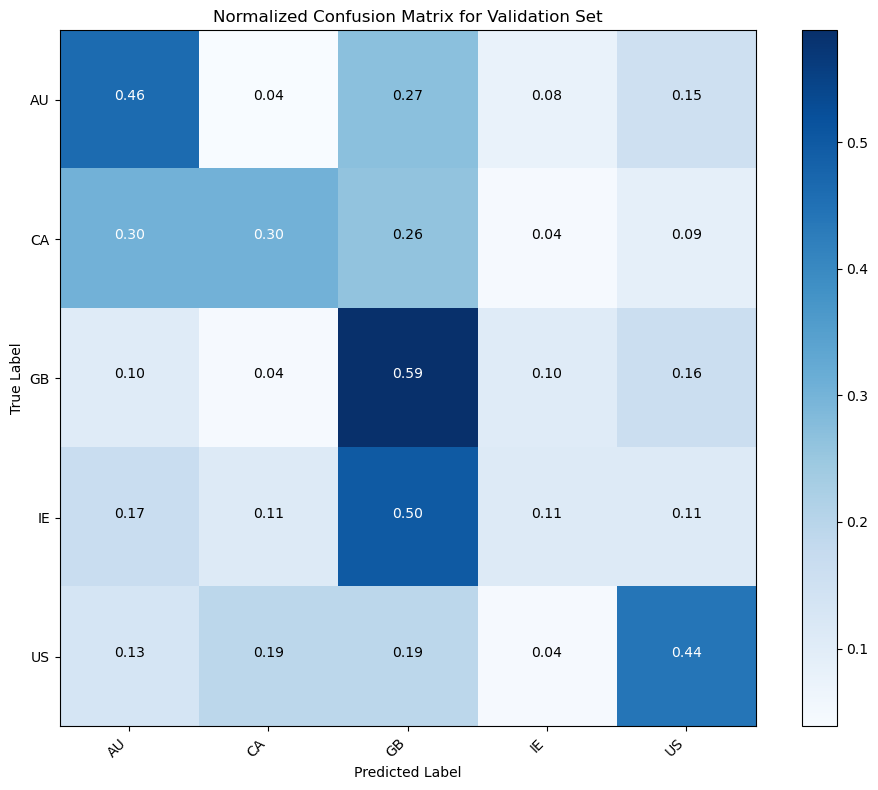

In [5]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Validation Set')
plt.tight_layout()
plt.show()

### Test on Now Data

In [6]:
now_data = pd.read_csv("https://raw.githubusercontent.com/imjnnanna/dialect-classifier/refs/heads/main/testing/now.csv")
now_data['text'] = now_data['text'].apply(preprocess_text)
now_data = now_data[now_data['country'].isin(allowed_codes)]

X_test = vectorizer.transform(now_data['text'])
y_test = label_encoder.transform(now_data['country'])

class_counts = np.bincount(y_test)
class_priors = class_counts / np.sum(class_counts)

model = MultinomialNB(class_prior=class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report_now = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model with now data:")
print(report_now)


Report for best model with now data:
              precision    recall  f1-score   support

          AU       0.20      0.20      0.20       147
          CA       0.55      0.28      0.37       351
          GB       0.38      0.61      0.47       385
          IE       0.33      0.16      0.22       267
          US       0.51      0.60      0.55       383

    accuracy                           0.42      1533
   macro avg       0.39      0.37      0.36      1533
weighted avg       0.42      0.42      0.40      1533



### Visualize Performance on Now Data Using Confusion Matrix

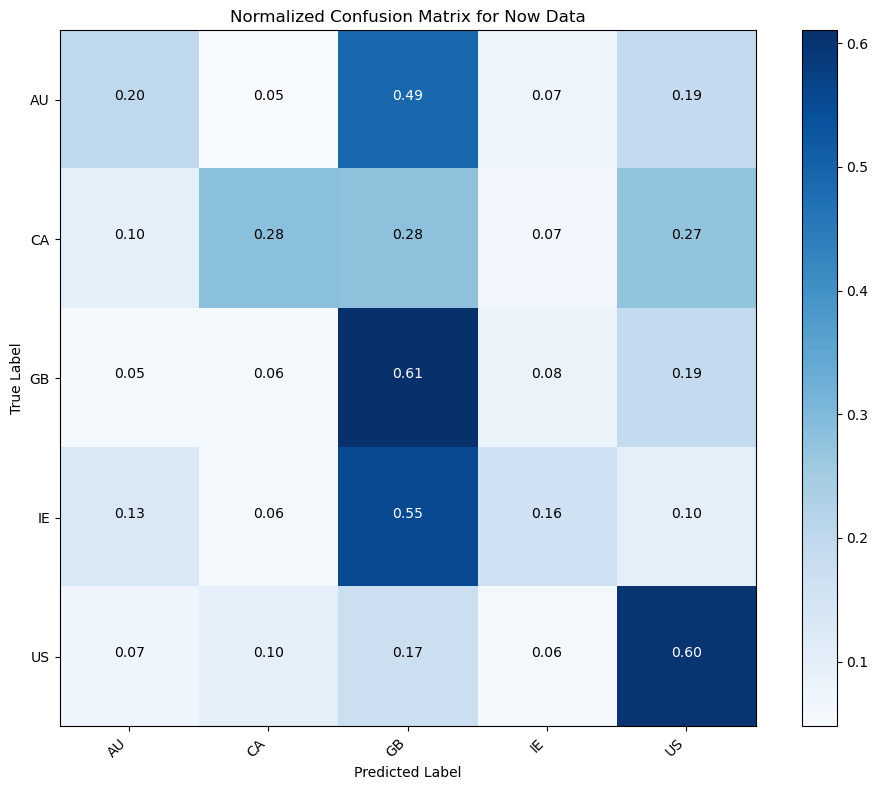

In [7]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Now Data')
plt.tight_layout()
plt.show()

### Test on Covid Data

In [16]:
covid_data = pd.read_csv("https://raw.githubusercontent.com/imjnnanna/dialect-classifier/refs/heads/main/testing/covid.csv")
covid_data['text'] = covid_data['text'].apply(preprocess_text)
covid_data = covid_data[covid_data['country'].isin(allowed_codes)]

X_test = vectorizer.transform(covid_data['text'])
y_test = label_encoder.transform(covid_data['country'])

class_counts = np.bincount(y_test)
class_priors = class_counts / np.sum(class_counts)

model = MultinomialNB(class_prior=class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report_covid = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model with Covid data:")
print(report_covid)

Report for best model with Covid data:
              precision    recall  f1-score   support

          AU       0.26      0.34      0.29       211
          CA       0.40      0.18      0.25       261
          GB       0.32      0.58      0.42       356
          IE       0.24      0.25      0.24       179
          US       0.83      0.72      0.77      1720

    accuracy                           0.59      2727
   macro avg       0.41      0.41      0.39      2727
weighted avg       0.64      0.59      0.60      2727



### Visualize Performance on Covid Data Using Confusion Matrix

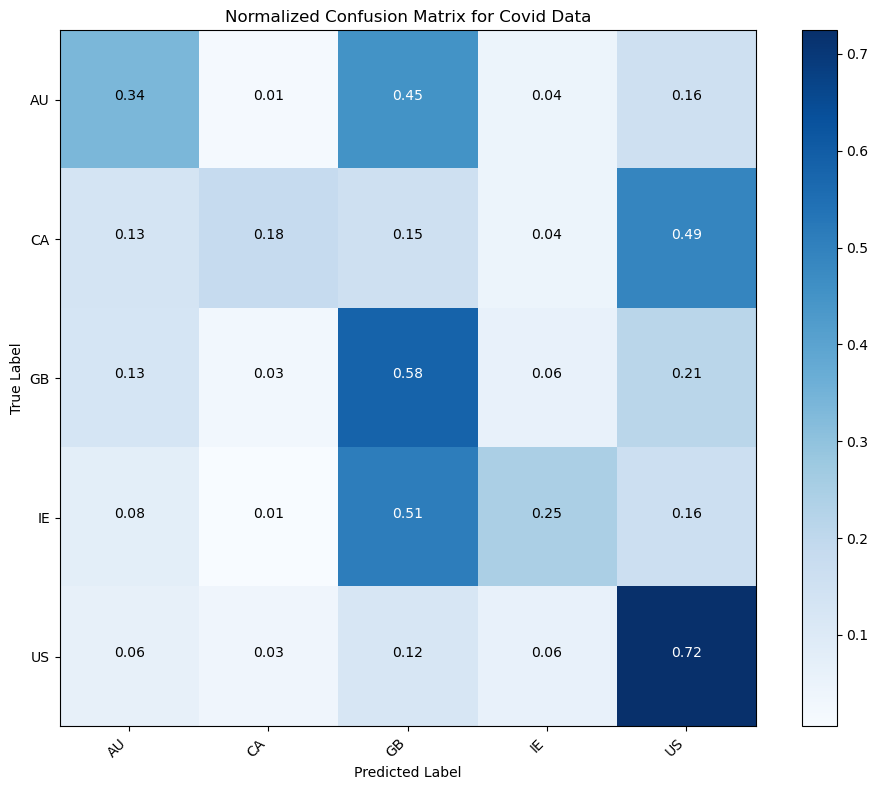

In [17]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Covid Data')
plt.tight_layout()
plt.show()

### Test on Media Data

In [21]:
media_data = pd.read_csv("https://raw.githubusercontent.com/imjnnanna/dialect-classifier/refs/heads/main/testing/media.csv")
media_data['text'] = media_data['text'].apply(preprocess_text)
media_data = media_data[media_data['country'].isin(allowed_codes)]

X_test = vectorizer.transform(media_data['text'])
y_test = label_encoder.transform(media_data['country'])

class_counts = np.bincount(y_test)
class_priors = class_counts / np.sum(class_counts)

model = MultinomialNB(class_prior=class_priors)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

report_media = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("Report for best model with media data:")
print(report_media)

Report for best model with media data:
              precision    recall  f1-score   support

          AU       0.02      1.00      0.04        11
          CA       0.00      0.00      0.00        32
          GB       0.78      0.08      0.14        90
          IE       0.00      0.00      0.00         1
          US       0.67      0.01      0.02       494

    accuracy                           0.04       628
   macro avg       0.29      0.22      0.04       628
weighted avg       0.64      0.04      0.04       628



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualize Performance on Media Data Using Confusion Matrix

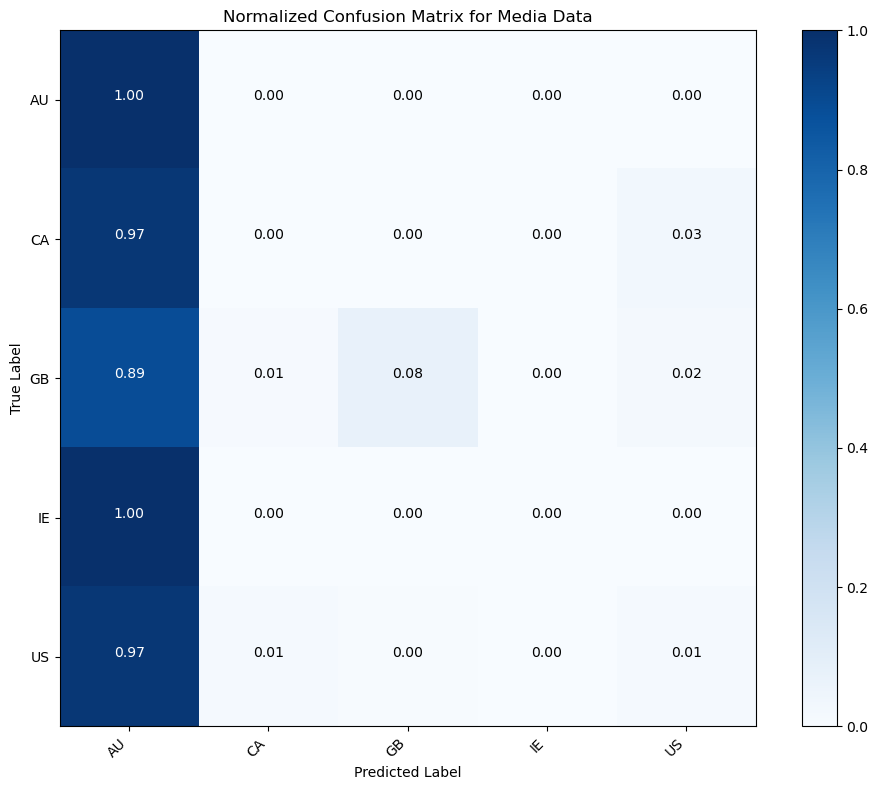

In [11]:
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

class_names = label_encoder.classes_
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

thresh = cm_normalized.max() / 2.0
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(
            j, i, f"{cm_normalized[i, j]:.2f}",
            horizontalalignment="center",
            color="white" if cm_normalized[i, j] > thresh else "black"
        )

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Media Data')
plt.tight_layout()
plt.show()